# MetOpts Lab3

##### imports

In [1599]:
import matplotlib.pyplot as plot
from matplotlib import style
import numpy as np
import math
from scipy.optimize import line_search
import warnings

# warnings.filterwarnings('ignore')
style.use('seaborn')
import pandas as pd

## Задание 1.   
Реализовать методы Gauss-Newton и Powell Dog Leg для решения нелинейной регрессии. Сравнить эффективность с методами реализованными в предыдущих работ.

---

Зададим функцию, для которой будем решать задачу линейной регрессии.  
Также напишем несколько метотов для отрисовки.

In [1600]:
def f(x, coef):
    return coef[0] + coef[1] * x + coef[2] * (x ** 2) + coef[3] * (x ** 3) + coef[4] * (x ** 4) + coef[5] * np.sin(x)

def draw(func, xs):
    min_point = xs[-1]
    pic = plot.figure(figsize=(10, 10))
    offset = max(np.max(xs[:, 0]), abs(np.min(xs[:, 0]))) * 2
    ls = np.linspace(min_point[0] - offset, min_point[0] + offset, 1000)
    plot.plot(ls, [func([x]) for x in ls])
    plot.plot(xs[:, 0], list(map(func,xs)), 'o-', color="red")
    plot.show()

def draw_func(ax, f, x, y, results,name):
    ax.scatter(x, y, s=15, label="Original point set", zorder=2)
    ax.plot(x, f(x, results), c='red', label=name, linewidth=1, zorder=1)
    ax.legend()

Методы `Gauss-Newton`, `Powell Dogleg` и их вспомогательные функции.

In [1601]:
def gauss_pinv(x):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T)

def powell_pinv(x):
    if not np.linalg.det(x.T.dot(x)):
        return x.T.dot(x).dot(x.T)
    return gauss_pinv(x)

def sum_quad_diff(f, x, y, c):
    return np.sum((f(x, c) - y) ** 2)

def jacobian(f, x, y, c, step):
    J = []
    y0 = f(x, c) - y

    for i in range(len(c)):

        new_x = c.copy()
        new_x[i] += step
        J.append((f(x, new_x) - y - y0) / step)

    return np.array(J).T

def hessian(J, c):
    return 2 * J.T.dot(J)

def powell_next(J, f, x, y, c):
    trusted = 1.0
    H = hessian(J, c)

    opt = -(np.linalg.pinv(H).dot(J))

    if np.sqrt(opt.dot(opt)) <= trusted: shift = opt
    else:
        cc = - (J.dot(J) / (J.dot(H.dot(J)))).dot(J)
        norm_c = np.sqrt(cc.dot(cc))

        if norm_c >= trusted:
            shift = trusted * cc / norm_c
        else:
            shift = cc + (trusted - cc) / (opt - cc) * (opt - cc)

    a_red = sum_quad_diff(f,x,y,c) - sum_quad_diff(f,x,y,c + shift)
    p_red = -(J.dot(shift) + 0.5 * (shift.dot(H.dot(shift))))

    if not p_red: rho = np.inf
    else: rho = a_red / p_red

    if rho > 0.15:
        return -shift
    else:
        return 0

Общий код решения нелинейной регресии.

In [1602]:
def gd(f, x, y, start, method, epochs=100, eps=1e-10):
    
    c = start.copy()
    error = np.inf
    diff = [sum_quad_diff(f, x, y, c)]
    
    for epoch in range(epochs):

        res = f(x, c) - y

        c -= method(jacobian(f, x, y, c, 1e-7)).dot(res)

        diff.append(sum_quad_diff(f, x, y, c))
        
        prev_error, error = error, np.sqrt(sum(res ** 2))
        if np.abs(prev_error - error) < eps:
            break

    return c, diff

Зададим набор точек принадлежащих функции и коэффициенты, характеризующие вышеописанную функцию.  
Также добавим разброс в значения Y ~~(чтобы жизнь медом не казалась)~~ и выберем стартовую точку.

In [1603]:
coef = [1, -0.5, 0.09, 0.005, 0.00001, 1.5]
x = np.linspace(-25., 10., 100)
y = f(x, coef)
yn = y + np.random.randn(len(x))
start = 1 * np.random.randn(len(coef))

Реализация спуска для использования с модификацией `Adam`.

In [1604]:
def autograd(f, x, y, c, eps=1e-5):
    res = np.zeros(len(c))
    step = np.zeros(len(c))
    for i in range(len(c)):
        step[i] = eps
        res[i] = (sum_quad_diff(f, x, y, c + step) - sum_quad_diff(f, x, y, c - step)) / (2 * eps)
        step[i] = 0
    return res

def applied_f_autograd(f, x, y):
    return lambda c: autograd(f, x, y, c)

def applied_f_arguments(f, x):
    return lambda c: f(x, c)

def applied_sum_quad_diff(f, x, y):
    return lambda c: sum_quad_diff(f, x, y, c)

def old_gd(f, x, y, start_point, method, epochs=10000, eps=1e-8):
    c = start_point.copy()
    diff = sum_quad_diff(f, x, y, c)
    diffs = [diff]
    for epoch in range(epochs):
        c = method(f, x, y, c)
        prev_diff, diff = diff, sum_quad_diff(f, x, y, c)
        diffs.append(diff)
        if abs(diff - prev_diff) < eps:
            break
    return c, np.array(diffs)

`Adam` из 2.3 почти без изменений.

In [1605]:
class Adam:
    def __init__(self, beta, gamma, lr, dim):
        self.eps = 1e-8
        self.lr = lr
        self.beta = beta
        self.gamma = gamma
        self.s1 = np.zeros(dim)
        self.s2 = np.zeros(dim)
    
    def __call__(self, func, x, y, coef):
        gr = autograd(func, x, y, coef)
        self.s1 = self.beta * self.s1 + (1 - self.beta) * gr
        self.s2 = self.gamma * self.s2 + (1 - self.gamma) * (gr ** 2)
        return coef - self.lr * self.s1 / (np.sqrt(self.s2) + self.eps)

Сравнения аппроксимаций функции различными методами.

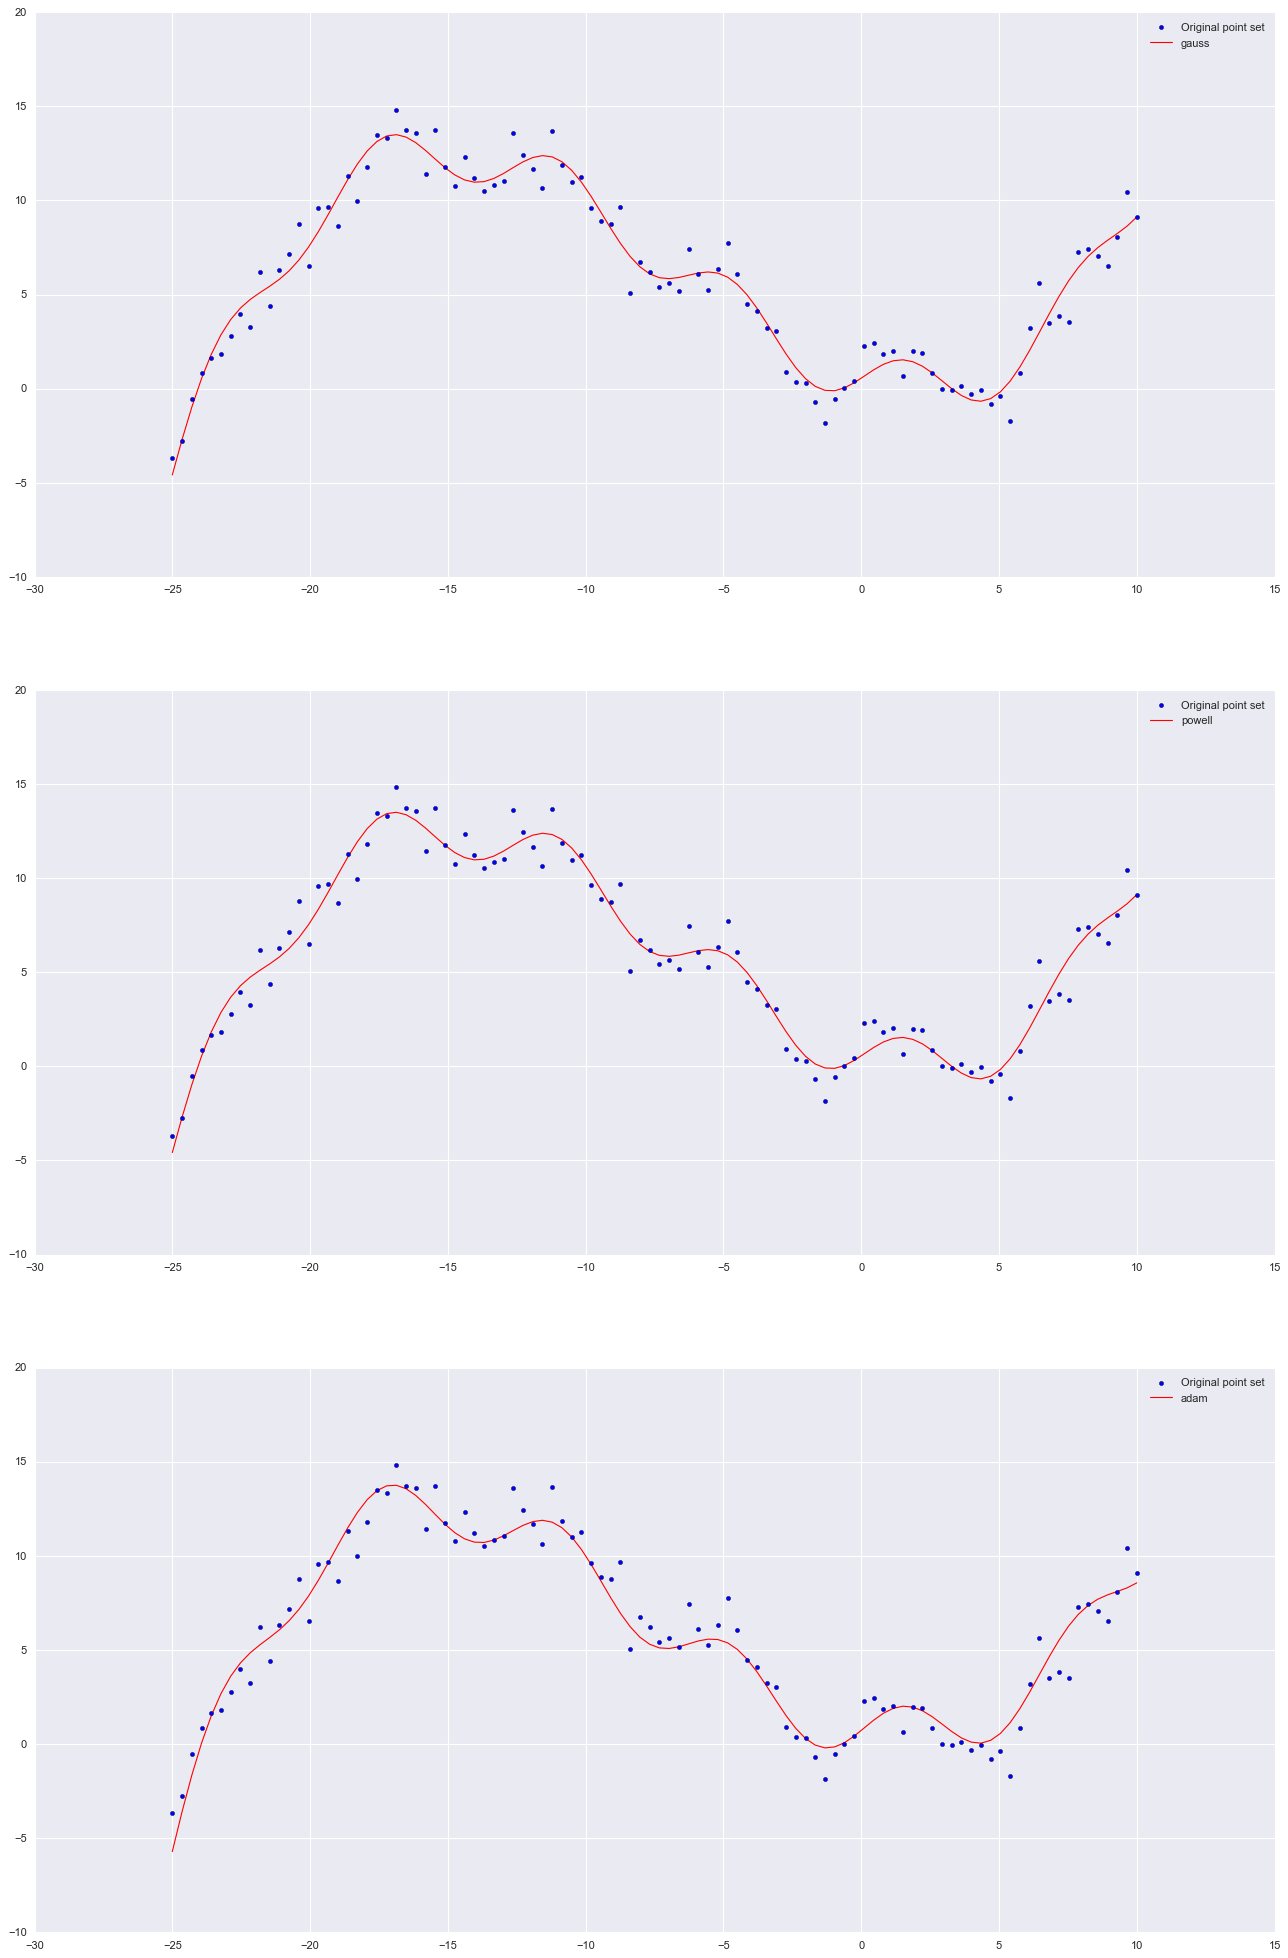

In [1606]:
fig, (ax1, ax2, ax3) = plot.subplots(3,1)
fig.set_size_inches(20,30)
gauss_result, gauss_diffs = gd(f, x, yn, start, gauss_pinv)
powell_result, powell_diffs = gd(f, x, yn, start, powell_pinv)
adam_result, adam_diffs = old_gd(f, x, yn, np.zeros(len(coef)), Adam(0.8, 0.8, 0.001, len(coef)))

draw_func(ax1, f, x, yn, gauss_result, "gauss")
draw_func(ax2, f, x, yn, powell_result,"powell")
draw_func(ax3, f, x, yn, adam_result, "adam")
plot.show()

Лучшие результаты в целом показали `Gauss-Newton` и `Powell Dogleg`.

## Задание 2.   
Реализовать метод BFGS и исследовать его сходимость при минимизации различных функций. Сравнить с другими реализованными методами.

---

Реализация `BFGS`

In [1607]:
def bfgs(f, df, start, epochs=100, eps=1e-8):
    cfs = start
    points = [cfs]

    I = np.eye(len(cfs))
    H = I.copy()
    
    gr = df(cfs)

    for epoch in range(epochs):
        p = - H.dot(gr)
        
        alpha = line_search(f, df, cfs, p, c1=1e-4, c2=0.9)[0]

        if alpha is None:
            s = 1e-4 * p
            # print("task failed successfully")
        else:
            s = alpha * p

        cfs = cfs + s
        points.append(cfs)

        ys = df(cfs) - gr
        gr = ys + gr
        
        if np.linalg.norm(gr) < eps:
            break

        ys = np.reshape(np.array([ys]), (len(cfs), 1))
        s = np.reshape(np.array([s]), (len(cfs), 1))

        r = 1. / (ys.T.dot(s))
        H = (I - r * s.dot(ys.T)).dot(H).dot((I - r * ys.dot(s.T))) + r * s.dot(s.T) #magic

    return np.array(points)

Функция Розенброка и ее градиент с коэффициентами `a = 1, b = 100`.


Минимум находится в точке `(1,1)`

In [1608]:
a=1
b=100

def rosenbrock(x):
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2


def rosenbrock_grad(x):
    return np.array([2 * (x[0] - a) + 4 * b * x[0] * (x[0] ** 2 - x[1]), 2 * b * (x[1] - x[0] ** 2)])


bfgs_points = bfgs(rosenbrock, rosenbrock_grad, np.array([-5., -3.]))
print(len(bfgs_points))
print(bfgs_points[-1])

26
[1. 1.]


`BFGS` нашел минимум (правильно). Также построим контур спуска.

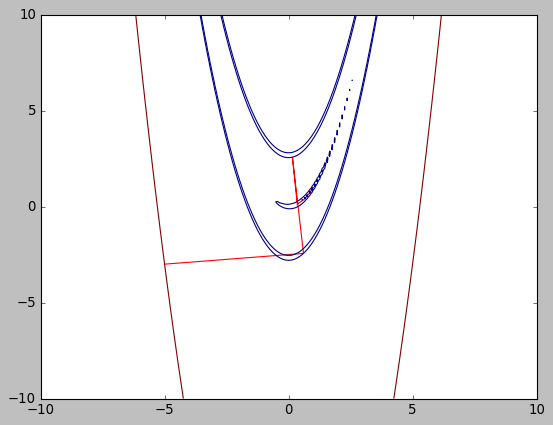

In [1609]:
plot.style.use("classic")
plot.plot(bfgs_points[:, 0], bfgs_points[:, 1], color='red')
xs, ys = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
plot.contour(xs, ys, rosenbrock(np.array([xs, ys])), levels=sorted(set(rosenbrock(p) for p in bfgs_points)))
plot.show()
plot.style.use("seaborn")

Возьмем функцию `f(x) = sin(x) + cos(x)` и соответствующий ей градиент. Запустим `BFGS` на этой функции. 

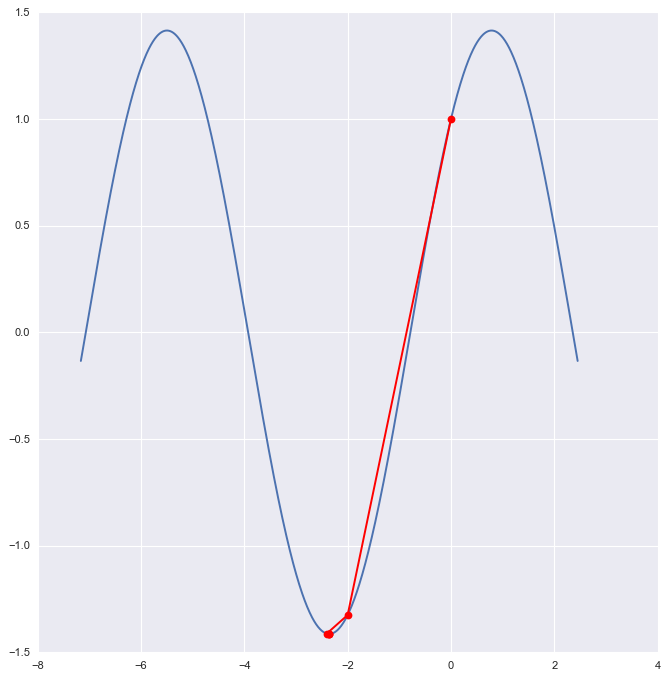

In [1610]:
def sf1(x):
    return np.sin(x[0]) + np.cos(x[0])

def grad_sf1(x):
    return np.array([np.cos(x[0]) - np.sin(x[0])])

draw(sf1, bfgs(sf1, grad_sf1, np.array([0.])))

Теперь сравним все методы, которые мы написали. Для этого выберем новую функцию. 

In [1611]:
def test_func(x,c):
   return c[0] + c[1] * x + c[2] * (x ** 2) + c[3] * (x ** 3) + c[4] * (x ** 4)
cfs = [6.,-8.,0.5,2.,-0.4]
x = np.linspace(-2.5, 4.5, 100)
y = test_func(x, cfs) + 0.4 * np.random.randn(len(x))
start = np.array([-1., -1.,-1. ,-1., -1.])

Построим аппроксимацию этой функции на разных методах.

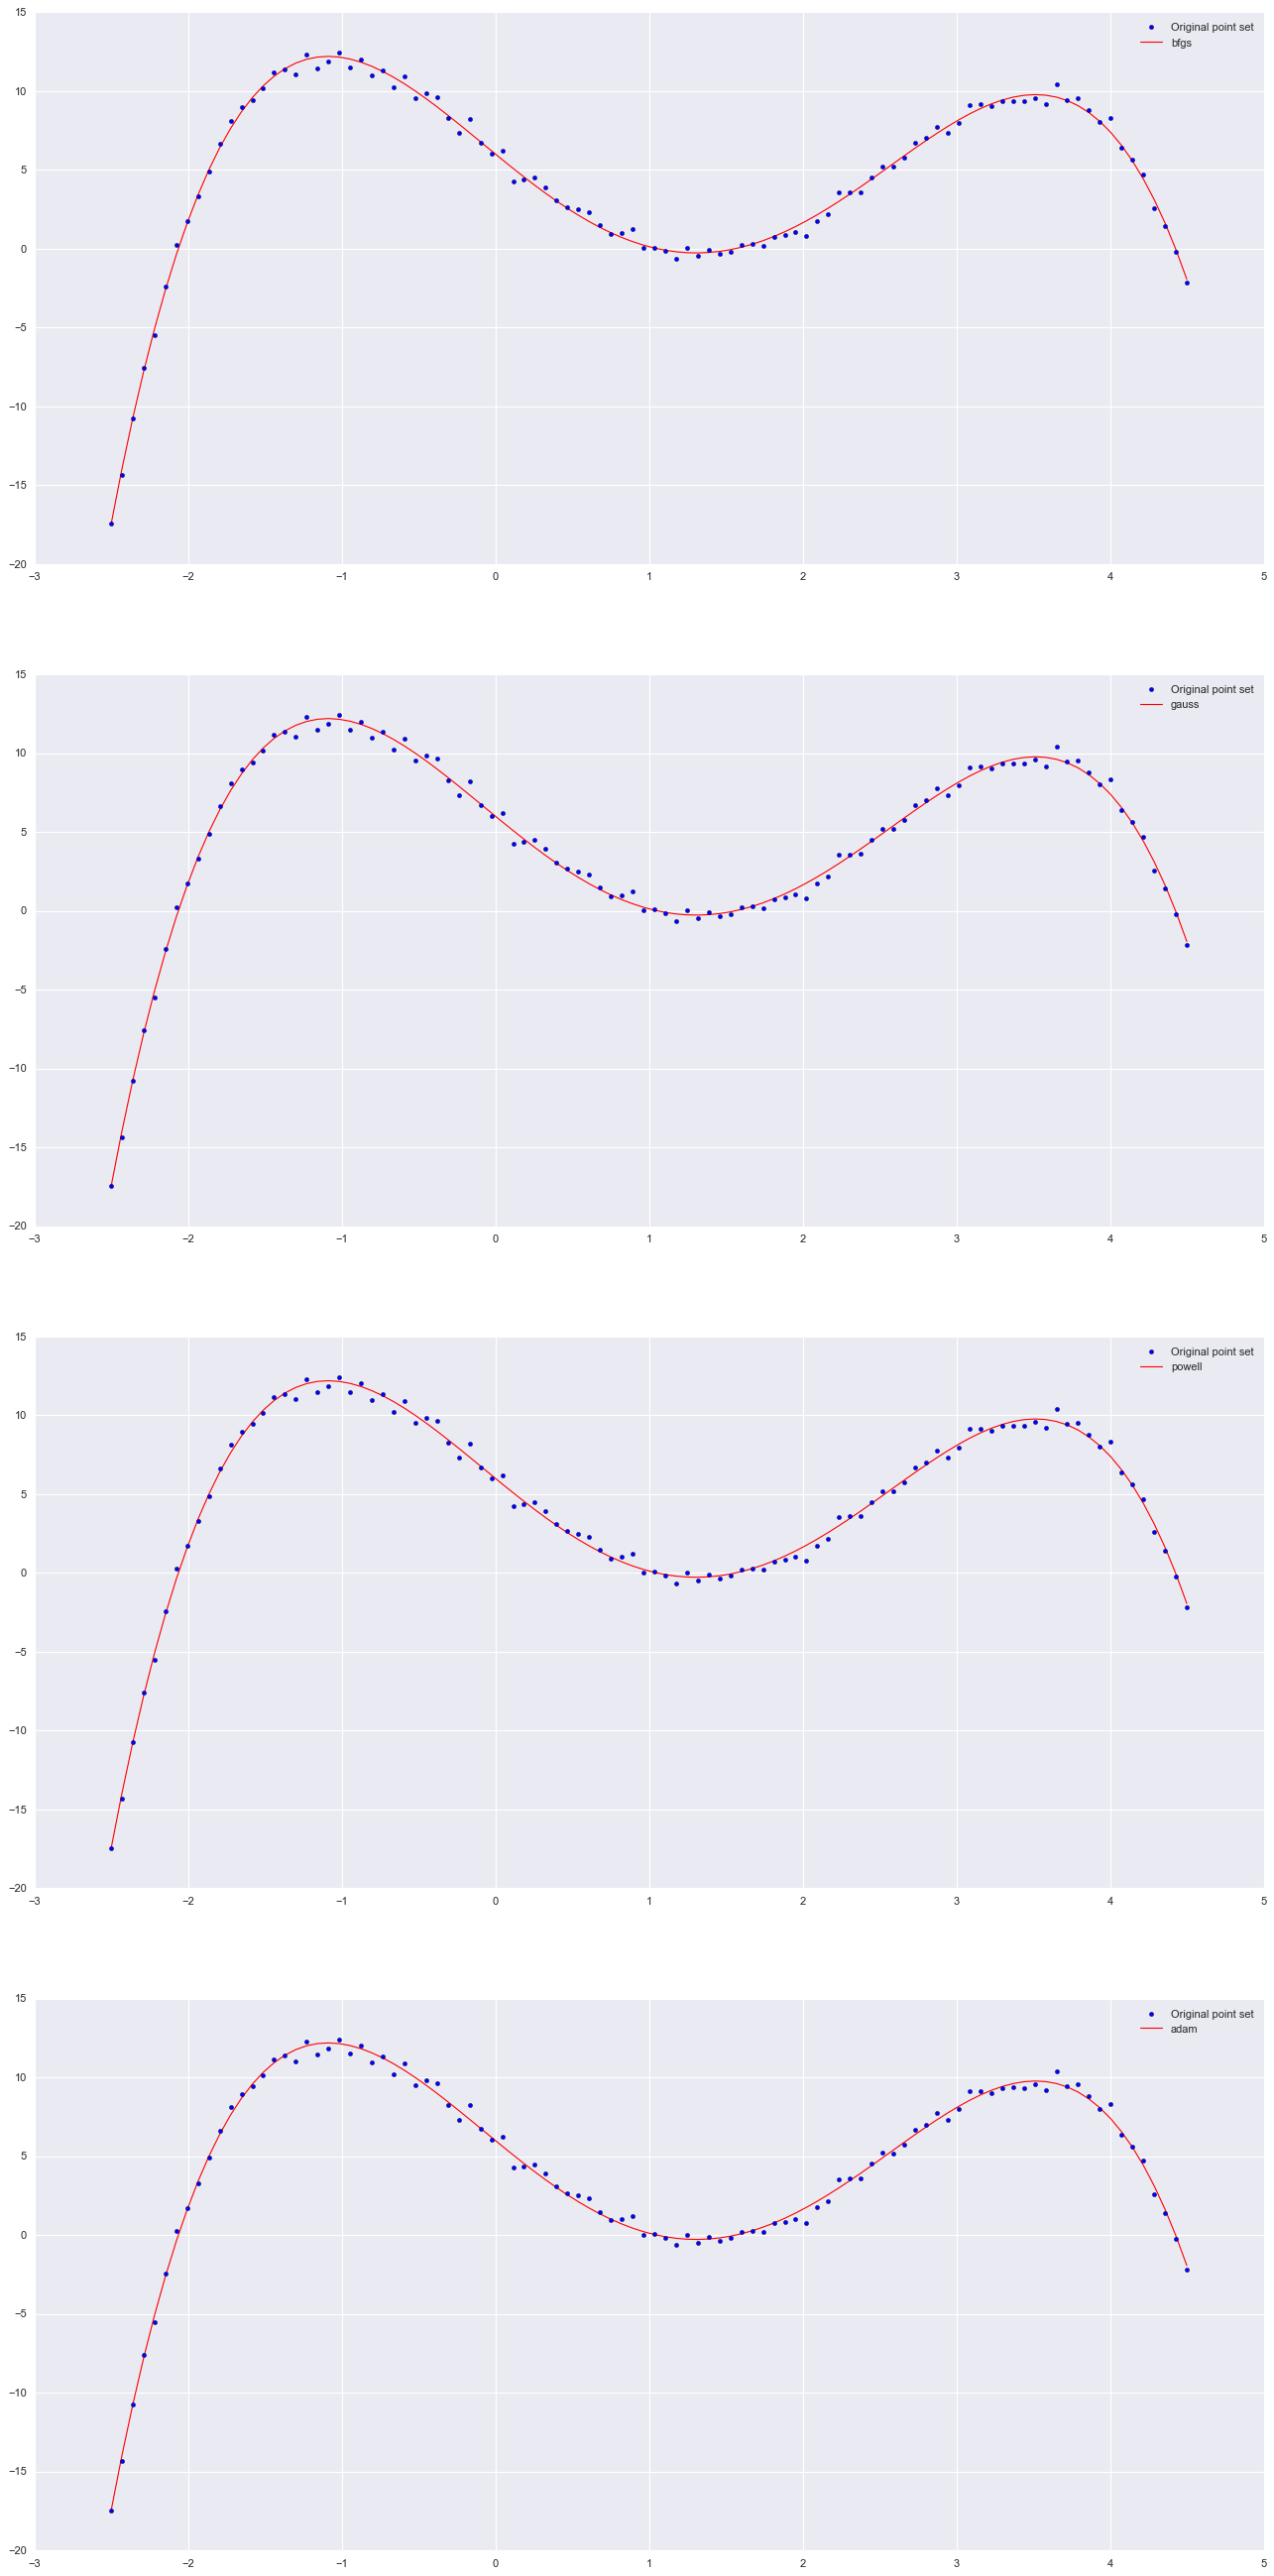

In [1612]:
fig,(ax1,ax2,ax3,ax4) = plot.subplots(4,1)
fig.set_size_inches(20,40)

bfgs_points = bfgs(applied_sum_quad_diff(test_func,x,y), applied_f_autograd(test_func,x,y), start)
gauss_result, gauss_diffs = gd(test_func, x, y, start, gauss_pinv)
powell_result, powell_diffs = gd(test_func, x, y, start, powell_pinv)
adam_result, adam_diffs = old_gd(test_func, x, y, start, Adam(0.8, 0.8, 0.001, len(cfs)))

draw_func(ax1,test_func,x,y,bfgs_points[-1],"bfgs")
draw_func(ax2,test_func,x,y,gauss_result,"gauss")
draw_func(ax3,test_func,x,y,powell_result,"powell")
draw_func(ax4,test_func,x,y,adam_result,"adam")
plot.show()

В целом, все методы показали себя хорошо.

Для более точного сравнения построим табличку со следующими данными: получившаяся функция ошибки и количество требуемых эпох для каждого метода

In [1613]:
data = []
epochs = list(map(lambda x: len(x) - 1,[bfgs_points,gauss_diffs,powell_diffs,adam_diffs]))
losses = list(map(applied_sum_quad_diff(test_func,x,y), [bfgs_points[-1], gauss_result, powell_result, adam_result]))

for i,name in enumerate(["bfgs","gauss", "powell", "adam"]):
    data.append([name,losses[i],epochs[i]])
    
pd.set_option('display.float_format', '{:.15e}'.format)
pd.DataFrame(data, columns=["name", "loss", "epochs"])


,name,loss,epochs
0,bfgs,1.486447105773184e+01,8
1,gauss,1.486447105773189e+01,3
2,powell,1.486447105773189e+01,3
3,adam,1.486648616850979e+01,10000


По табличке видим, что `BFGS` нашел более точный минимум, хоть на это и потребовалось больше эпох чем методу `Gauss-Newton` и `Powell Dogleg`. `Adam` же показал наихудший результат и по функции ошибки и по количеству эпох, помянем.🙏